<font color=blue>
Supriya Raman<br>
HMMs and Viterbi Algorithm for POS Tagging Assignment <br>
6th April, 2020
    </font>

# <font color=navy> <u> HMMs and Viterbi Algorithm for POS Tagging Assignment </font>
## <font color=navy> POS tagging using modified Viterbi </font>

#### <font color=navy> Problem Statement: </font> <br>
<font color=brown>
Using the Penn Treebank Universal training set corpus, build a Viterbi PoS tagger, then enhance it to solve the problem of unknown words. </font>

#### <font color=navy> Goals: </font> <br>
The below model is developed to perform POS tagging using modified Viterbi: 
- To write the Vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
- To solve the problem of unknown words using at least two techniques. 
- To compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
- To list down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

## <font color=brown> Table of Contents </font>
<a href='#Step 1'> Step 1: Data Preparation </a> <br>
<a href='#Step 2'> Step 2: Build the vanilla Viterbi based POS tagger </a> <br>
<a href='#Step 3'> Step 3: Solve the problem of unknown words </a> <br>
<a href='#Step 4'> Step 4: Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm </a> <br>
<a href='#Step 5'> Step 5: List down cases incorrectly tagged by original POS tagger and got corrected by modifications </a> <br>

## <font color=brown> Step 1: Data Preparation <a id='Step 1'></a> </font>
Importing all required Python Libraries and Reading Treebank tagged sentences

In [1]:
#Importing libraries
import nltk, re
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import pprint, time

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
nltk_data[:2]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')]]

In [3]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print("Training Set Length -", len(train_set))
print("Training Set Length -", len(test_set))
print("-" * 100)
print("Training Dataset  -\n")
print(train_set[:5])

Training Set Length - 3718
Training Set Length - 196
----------------------------------------------------------------------------------------------------
Training Dataset  -

[[('Rep.', 'NOUN'), ('James', 'NOUN'), ('Traficant', 'NOUN'), ('-LRB-', '.'), ('D.', 'NOUN'), (',', '.'), ('Ohio', 'NOUN'), ('-RRB-', '.'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('the', 'DET'), ('amendment', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-19', 'X'), ('passed', 'VERB'), ('271-147', 'NUM'), (',', '.'), ('would', 'VERB'), ('``', '.'), ('let', 'VERB'), ('the', 'DET'), ('American', 'ADJ'), ('worker', 'NOUN'), ('know', 'VERB'), ('that', 'ADP'), ('we', 'PRON'), ('consider', 'VERB'), ('them', 'PRON'), ('occasionally', 'ADV'), ('.', '.'), ("''", '.')], [('The', 'DET'), ('drug', 'NOUN'), ('was', 'VERB'), ('approved', 'VERB'), ('*-1', 'X'), ('by', 'ADP'), ('the', 'DET'), ('Food', 'NOUN'), ('and', 'CONJ'), ('Drug', 'NOUN'), ('Administration', 'NOUN'), ('and', 'CONJ'), ('marketed', 'VERB'), ('*-1', 'X'), ('by

In [4]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
print("Count of Tagged Words in Training Set: " + str(len(train_tagged_words)))

Count of Tagged Words in Training Set: 95673


In [5]:
# Let's have a look at the tagged words in the training set
train_tagged_words[:10]

[('Rep.', 'NOUN'),
 ('James', 'NOUN'),
 ('Traficant', 'NOUN'),
 ('-LRB-', '.'),
 ('D.', 'NOUN'),
 (',', '.'),
 ('Ohio', 'NOUN'),
 ('-RRB-', '.'),
 (',', '.'),
 ('said', 'VERB')]

In [6]:
# tokens in the train set - train_tagged_words
train_data_tokens = [pair[0] for pair in train_tagged_words]
train_data_tokens[:10]

['Rep.',
 'James',
 'Traficant',
 '-LRB-',
 'D.',
 ',',
 'Ohio',
 '-RRB-',
 ',',
 'said']

In [7]:
# POS tags for the tokens in the train set -
train_data_pos_tags = [pair[1] for pair in train_tagged_words]
train_data_pos_tags[:10]

['NOUN', 'NOUN', 'NOUN', '.', 'NOUN', '.', 'NOUN', '.', '.', 'VERB']

In [8]:
# building the train vocabulary to a set
training_vocabulary_set = set(train_data_tokens)

In [9]:
# building the POS tags to a set
training_pos_tag_set = set(train_data_pos_tags)
print(training_pos_tag_set)

{'DET', 'PRT', 'NUM', 'NOUN', 'ADP', 'PRON', 'X', 'ADV', '.', 'CONJ', 'ADJ', 'VERB'}


In [10]:
# Length of POS Tags and Vocabulary
print("Length Of: \n-  Vocabulary: {} \n-  POS Tags: {}".format(len(training_vocabulary_set), len(training_pos_tag_set)))

Length Of: 
-  Vocabulary: 12067 
-  POS Tags: 12


<b> POS Tagging algorithm using Hidden Markov Model (HMM)</b>
We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. In other words, to every word w, assign the tag t that maximises the likelihood P(t/w).

Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).
Now:

- P(w/t): is the emission probability of a given word for a given tag. This can be computed based on the fraction of given word for given tag to the total count of that tag, ie: P(w/t) = count(w, t) / count(t).

- P(t): is the probability of tag (also transition probability), and in a tagging task, we assume that a tag will depend only on the previous tag (Markov order 1 assumption). In other words, the probability of say a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).

In [11]:
# Emission Probabilities - Function to compute emission probabilties for a given word
# computing P(w/t) and storing in [Tags x Vocabulary] matrix. This is a matrix with dimension
# of len(training_pos_tag_set) X en(training_vocabulary_set)
len_pos_tags = len(training_pos_tag_set)
len_vocab = len(training_vocabulary_set)
word_given_tag = np.zeros((len_pos_tags, len_vocab))

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [13]:
# Transition Probabilities - Function to compute transition probabilties for a given tag and previous tag
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [14]:
# Testing the above method for Transition Probability
t2_given_t1('NOUN','DET')

(5322, 8302)

In [15]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float32')
for i, t1 in enumerate(list(training_pos_tag_set)):
    for j, t2 in enumerate(list(training_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [16]:
tags_matrix

array([[  5.42038074e-03,   2.40905807e-04,   2.21633334e-02,
          6.41050339e-01,   8.91351514e-03,   3.49313417e-03,
          4.57721017e-02,   1.24066491e-02,   1.81883890e-02,
          4.81811614e-04,   2.02240422e-01,   3.96290049e-02],
       [  1.00587852e-01,   1.95950363e-03,   5.74787706e-02,
          2.47224033e-01,   2.02482045e-02,   1.69823635e-02,
          1.40431095e-02,   1.04506854e-02,   4.31090780e-02,
          2.28608749e-03,   8.39320719e-02,   4.01698232e-01],
       [  3.26312659e-03,   2.75882520e-02,   1.84811622e-01,
          3.52714330e-01,   3.50044481e-02,   1.48323935e-03,
          2.09136754e-01,   2.37318315e-03,   1.18362501e-01,
          1.36458026e-02,   3.35212089e-02,   1.80955213e-02],
       [  1.33978957e-02,   4.39072326e-02,   9.24746040e-03,
          2.64171541e-01,   1.77230865e-01,   4.80576698e-03,
          2.88710091e-02,   1.71114430e-02,   2.39851460e-01,
          4.24873494e-02,   1.20508242e-02,   1.46867156e-01],
    

In [17]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(training_pos_tag_set), index=list(training_pos_tag_set))

In [18]:
# dataset glimpse
tags_df

,DET,PRT,NUM,NOUN,ADP,PRON,X,ADV,.,CONJ,ADJ,VERB
DET,0.005420,0.000241,0.022163,0.641050,0.008914,0.003493,0.045772,0.012407,0.018188,0.000482,0.202240,0.039629
PRT,0.100588,0.001960,0.057479,0.247224,0.020248,0.016982,0.014043,0.010451,0.043109,0.002286,0.083932,0.401698
NUM,0.003263,0.027588,0.184812,0.352714,0.035004,0.001483,0.209137,0.002373,0.118363,0.013646,0.033521,0.018096
NOUN,0.013398,0.043907,0.009247,0.264172,0.177231,0.004806,0.028871,0.017111,0.239851,0.042487,0.012051,0.146867
ADP,0.324667,0.001492,0.062227,0.322003,0.016942,0.069153,0.034949,0.013213,0.038892,0.000746,0.107299,0.008418
PRON,0.009623,0.012317,0.007698,0.210162,0.022325,0.007313,0.092764,0.035027,0.040031,0.005389,0.074673,0.482679
X,0.054377,0.184660,0.002870,0.062669,0.144156,0.055175,0.075267,0.026152,0.163132,0.010206,0.017063,0.204274
ADV,0.069310,0.014995,0.031989,0.030990,0.119294,0.014995,0.023659,0.077974,0.132622,0.006998,0.129957,0.347218
.,0.173831,0.002518,0.081025,0.222752,0.091097,0.065558,0.026799,0.051888,0.093255,0.058363,0.044604,0.088219
CONJ,0.119535,0.005116,0.042326,0.347907,0.053953,0.059070,0.007442,0.053953,0.035814,0.000465,0.118605,0.155814


In [19]:
tags_df.loc['.', :]

DET     0.173831
PRT     0.002518
NUM     0.081025
NOUN    0.222752
ADP     0.091097
PRON    0.065558
X       0.026799
ADV     0.051888
.       0.093255
CONJ    0.058363
ADJ     0.044604
VERB    0.088219
Name: ., dtype: float32

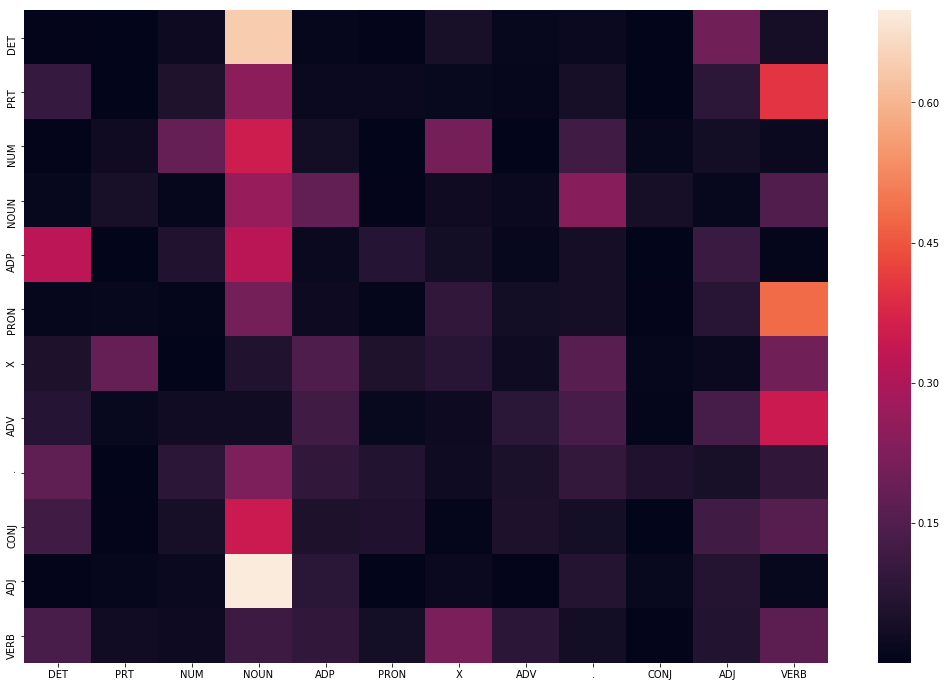

In [20]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

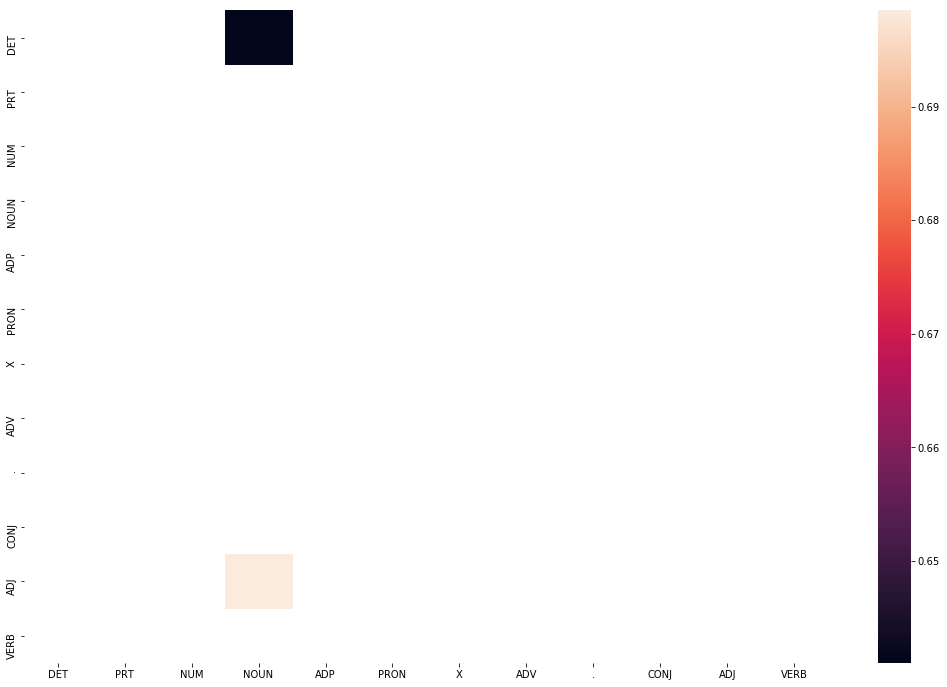

In [21]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### <font color=brown> Step 2: Build the vanilla Viterbi based POS tagger <a id='Step 2'></a> </font>

The steps are as follows:
- Given a sequence of words
- Iterate through the sequence
- For each word (starting from first word in sequence) calculate the product of emission probabilties and transition probabilties for all possible tags.
- Assign the tag which has maximum probability obtained in step 3 above.
- Move to the next word in sequence to repeat steps 3 and 4 above

In [22]:
# Vanilla Viterbi Algorithm
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [23]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [24]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  9.204278230667114


In [25]:
# Let's check the accuracy of the vanilla viterbi algorithm
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

vanilla_viterbi_accuracy = len(check)/len(tagged_seq)
print('Vanilla Viterbi Algorithm Accuracy: ',vanilla_viterbi_accuracy*100)

Vanilla Viterbi Algorithm Accuracy:  84.44444444444444


In [26]:
# let's check the incorrectly tagged words
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
incorrect_tagged_cases

14


[[(',', '.'), (('Commodore', 'DET'), ('Commodore', 'NOUN'))],
 [('Commodore', 'NOUN'), (('Pet', 'DET'), ('Pet', 'NOUN'))],
 [('and', 'CONJ'), (('Tandy', 'DET'), ('Tandy', 'NOUN'))],
 [('Tandy', 'NOUN'), (('TRS-80', 'DET'), ('TRS-80', 'NOUN'))],
 [('the', 'DET'), (('Natural', 'DET'), ('Natural', 'NOUN'))],
 [('large', 'ADJ'), (('hypothetical', 'DET'), ('hypothetical', 'ADJ'))],
 [('seller', 'NOUN'), (('trade', 'NOUN'), ('trade', 'VERB'))],
 [('the', 'DET'), (('flightiness', 'DET'), ('flightiness', 'NOUN'))],
 [('will', 'VERB'), (('diminish', 'DET'), ('diminish', 'VERB'))],
 [('the', 'DET'), (('East', 'NOUN'), ('East', 'ADJ'))],
 [('East', 'ADJ'), (('Anglian', 'DET'), ('Anglian', 'ADJ'))],
 [('group', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('*T*-223', 'DET'), ('*T*-223', 'X'))],
 [('bells', 'NOUN'), (('pealing', 'DET'), ('pealing', 'VERB'))]]

Before proceeding for dealing with unknown words, lets first see how many unknown words we have. Unknows words would be
those words that are present in the test set but not in the train set. That is the words the algorithm has not seen before.

In [27]:
# Finding list of Unknown words 
test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 11


Unknown Words : ['Commodore', 'flightiness', 'diminish', 'Pet', 'TRS-80', 'Anglian', 'Natural', 'hypothetical', 'pealing', 'Tandy', '*T*-223']


In [28]:
## Testing the Viterbi function on a random sentence
sentence_test = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [29]:
print(tagged_seq)
print(difference)

[('The', 'DET'), ('2018', 'DET'), ('FIFA', 'DET'), ('World', 'NOUN'), ('Cup', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'DET'), ('FIFA', 'DET'), ('World', 'NOUN'), ('Cup', 'DET'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'DET'), ('contested', 'DET'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]
2.2346913814544678


### <font color=brown> Step 3: Solve the problem of unknown words <a id='Step 3'></a> </font>
1. Use lexical techniqies on the same data to see if we get better <br>
2. Use these to tag unknown words, then see if we get better.

#### <u> <font color=brown> Method 1 </u>

The default Vanilla Viterbi algorithm achieved an accuracy of about 84.44%. This approx. 16% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'COVID'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

Now lets see how we can minimize this loss by modifying the Vanilla Viterbi.

If a word is not present in the training vocabulary (unknown word), its emission probability will be ZERO. In that case the state probability will inturn be zero. Thus in cases where the algorithm encounters a word which it has not see previously, we can omit the emission probability and only consider the transition probability.

The algorithm can be modified to deal the case as below - <br>
<br><b> <font color=navy>
If word in unknown Then <br>
Consider only the transition_p (emission probability being 0)<br>
Else<br>
Consider both the emission and transition probability.</font>

<b><u> Modified Vanilla Viterbi

In [30]:
# Modified Viterbi Heuristic
def Vanilla_Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            # to consider unknown words
            if word not in training_vocabulary_set:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [31]:
# tagging the test sentences
unknown_word_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(test_tagged_words)

# accuracy
unknown_word_check = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]

optimized_viterbi_accuracy = (len(unknown_word_check)/len(unknown_word_tagged_seq)) * 100

print("The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is -", optimized_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is - 91.11111111111111


The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is - 91.11%

We see the modified viterbi algorithm performs better than the original vanilla viterbi algorithm. The modified viterbi achieves an accuracy of (approx.) 91.11% comapred to 84.44% of the vanilla viterbi.

Still there is an overall loss of approx. 9%.

Now, lets see if we can in reduce this loss further.

#### Let's try with some Lexicon and Rule-Based Models for POS Tagging.
####  <u> Unigram Tagger

In [33]:
# Unigram Tagger
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", unigram_tagger_accuracy*100)

The accuracy of the Unigram Tagger is - 89.84609234459325


Let's now try combining the unigram tagger with a rule based regex tagger.

In [34]:
# patterns for tagging using a rule based regex tagger -

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

<u> <b>Rule based RegexpTagger

In [35]:
# rule based RegexpTagger

rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger backed up by the RegexpTagger is -", accuracy_rule_based_unigram_tagger*100)

The accuracy of the Unigram Tagger backed up by the RegexpTagger is - 93.40395762542475


<u> <b>Bigram Tagger

In [36]:
# Bigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is -", accuracy_bigram_tagger*100)

The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is - 93.88366979812113


<u> <b>Trigram Tagger

In [37]:
# Trigram tagger

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("The accuracy of the Trigram Tagger backed up by the bigram_tagger is -", accuracy_trigram_tagger*100)

The accuracy of the Trigram Tagger backed up by the bigram_tagger is - 93.78372976214271


Getting marginally better, but not by much.
Next lets see if we can use this for the unknown words

Now to build this into viterbi, need to change the regex patterns to fit for the tags in our data (NOUN instead of NNS etc)

#### <u> <font color=brown> Method 2 </font> </u>

We see that the Trigram Tagger backed up by the bigram tagger gives an accuracy of about 94.85%. Let's now try to modify the viterbi algorithm to use this trigram tagger as a back-off.

When the viterbi algorithm is not able to tag an unknown word, it uses the rule-based tagger.

<u> <b>Trigram Tagger backed off by a rule based tagger

In [38]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [39]:
def viterbi_backedup_by_trigram_tagger(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in training_vocabulary_set:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [40]:
# tagging the test sentences
viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(test_tagged_words)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)

print("The accuracy of the viterbi_backedup_by_trigram_tagger is -", viterbi_trigram_accuracy*100)

The accuracy of the viterbi_backedup_by_trigram_tagger is - 93.33333333333333


### <font color=brown> Step 4: Compare the tagging accuracies of the modifications with the Vanilla Viterbi algorithm <a id='Step 4'></a> </font>

<b> <u> Check the tagging accuracy on the test_set data generated using the test_train_split

In [41]:
acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy*100], 
                  ['Optimized Vanilla Viterbi', optimized_viterbi_accuracy], 
                  ['Unigram Tagger', unigram_tagger_accuracy*100],
                  ['Unigram + RegexpTagger', accuracy_rule_based_unigram_tagger*100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,84.444444
Optimized Vanilla Viterbi,91.111111
Unigram Tagger,89.846092
Unigram + RegexpTagger,93.403958
Bigram Tagger + Unigram_tagger,93.883670
Trigram Tagger + Bigram_tagger,93.783730
Viterbi + Trigram_tagger,93.333333


<b> <u> Plotting the graph for Tagging Accuracy

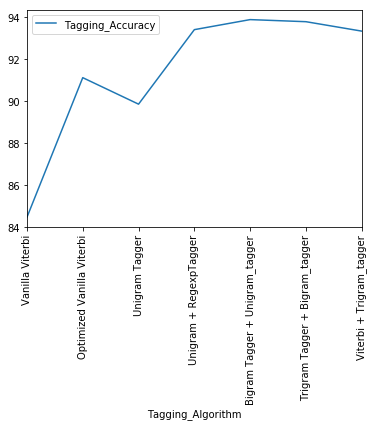

In [42]:
acccuracy_data_df.plot.line(rot = 90, legend = True)
plt.show()

<b> <u> Checking the tagging accuracies for the algorithm on the sample test sentences provided - 

In [43]:
sample_test_sentences = ['Android is a mobile operating system developed by Google.',
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

In [44]:
sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sentences]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [45]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]


# list of tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]

In [46]:
sample_test_tagged_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

(1) Testing the accuracy of Vanilla Viterbi on sample test data -

In [48]:
# tagging the test sentences
sample_test_tagged_seq = Viterbi(sample_test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_test_run_base) if i == j]

vanilla_viterbi_accuracy = len(sample_test_check)/len(sample_test_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm on the sample test data is -", vanilla_viterbi_accuracy*100)

The accuracy of the Vanilla Viterbi Algorithm on the sample test data is - 75.13812154696133


(2) Testing the accuracy of Vanilla_Viterbi_for_Unknown_Words on sample test data -

In [49]:
# tagging the test sentences
sample_test_unknown_word_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(sample_test_tagged_words)

# accuracy
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_optimized_viterbi_accuracy = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)

print("The accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is -", sample_test_optimized_viterbi_accuracy*100)

The accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is - 86.1878453038674


(3) Testing the accuracy of viterbi_backedup_by_trigram_tagger on sample test data -

In [51]:
# tagging the test sentences
sample_test_viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(sample_test_tagged_words)

# accuracy
sample_test_viterbi_trigram_check = [i for i, j in zip(sample_test_viterbi_trigram_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_viterbi_trigram_accuracy = len(sample_test_viterbi_trigram_check)/len(sample_test_viterbi_trigram_tagged_seq)

print("The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is -", sample_test_viterbi_trigram_accuracy*100)

The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is - 92.81767955801105


<b> <u> Comparing the accuracies of the 3 algorithm on sample test data -

In [52]:
acccuracy_on_sample_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy*100], 
                  ['Optimized Vanilla Viterbi', sample_test_optimized_viterbi_accuracy*100], 
                  ['Viterbi + Trigram_tagger', sample_test_viterbi_trigram_accuracy*100]]

sample_test_data_acccuracy_df = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

sample_test_data_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

sample_test_data_acccuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,75.138122
Optimized Vanilla Viterbi,86.187845
Viterbi + Trigram_tagger,92.817680


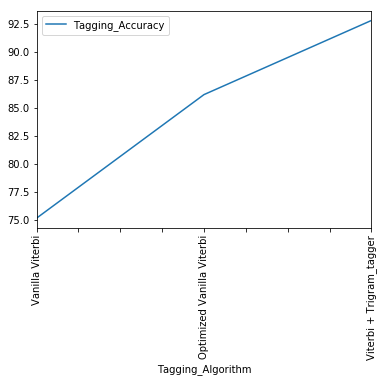

In [55]:
sample_test_data_acccuracy_df.plot.line(rot = 90, legend = True)
plt.show()

### <font color=brown> Step 5: List down cases incorrectly tagged by original POS tagger and corrected by  modifications <a id='Step 5'></a> </font>

In [56]:
# test sentences
test_sentence_1 = 'Android is a mobile operating system developed by Google.'
test_sentence_2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
test_sentence_3 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
test_sentence_4 = 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
test_sentence_5 = 'Before entering politics, Donald Trump was a domineering businessman and a television personality.'
test_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
test_sentence_7 = 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.'
test_sentence_8 = 'Show me the cheapest round trips from Dallas to Atlanta'
test_sentence_9 = 'I would like to see flights from Denver to Philadelphia.'
test_sentence_10 = 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.'
test_sentence_11 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'

<b> <u> Case - 1

In [57]:
# test_sentence_1 = 'Android is a mobile operating system developed by Google.'

words_test_sentence_1 = nltk.word_tokenize(test_sentence_1)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Viterbi(words_test_sentence_1)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*100)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(words_test_sentence_1)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]


----------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


In [58]:
cols = ['vanilla_viterbi_tags', 'viterbi_trigram_tags_with_corrections']
tags_correction_df_1 = pd.DataFrame(columns = cols)
tags_correction_df_1 = tags_correction_df_1.fillna(0)

tags_correction_df_1.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi]
tags_correction_df_1.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram]

tags_correction_df_1

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Android, DET)","(Android, NOUN)"
1,"(is, VERB)","(is, VERB)"
2,"(a, DET)","(a, DET)"
3,"(mobile, ADJ)","(mobile, ADJ)"
4,"(operating, NOUN)","(operating, NOUN)"
5,"(system, NOUN)","(system, NOUN)"
6,"(developed, VERB)","(developed, VERB)"
7,"(by, ADP)","(by, ADP)"
8,"(Google, DET)","(Google, NOUN)"
9,"(., .)","(., .)"


As we see above in the sample test sentence 1, the word 'Android' was tagged as DET by vanilla viterbi. The modified algorithm of viterbi backed up by trigram tagger corrected this and tagged 'Android' as NOUN.

<b> <u> Case - 2

In [59]:
# test_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, 
#                   an international football tournament contested once every four years.'

words_test_sentence_6 = nltk.word_tokenize(test_sentence_6)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_6 = Viterbi(words_test_sentence_6)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi_6)

print('\n')
print('-'*100)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram_6 = viterbi_backedup_by_trigram_tagger(words_test_sentence_6)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_6)

Tagging sequence with Vanilla_Viterbi -

 [('The', 'DET'), ('2018', 'DET'), ('FIFA', 'DET'), ('World', 'NOUN'), ('Cup', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'DET'), ('FIFA', 'DET'), ('World', 'NOUN'), ('Cup', 'DET'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'DET'), ('contested', 'DET'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


----------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


In [60]:
tags_correction_df_6 = pd.DataFrame(columns = cols)
tags_correction_df_6 = tags_correction_df_6.fillna(0)

tags_correction_df_6.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_6]
tags_correction_df_6.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_6]

tags_correction_df_6

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(The, DET)","(The, DET)"
1,"(2018, DET)","(2018, NUM)"
2,"(FIFA, DET)","(FIFA, NOUN)"
3,"(World, NOUN)","(World, NOUN)"
4,"(Cup, DET)","(Cup, NOUN)"
5,"(is, VERB)","(is, VERB)"
6,"(the, DET)","(the, DET)"
7,"(21st, DET)","(21st, NUM)"
8,"(FIFA, DET)","(FIFA, NOUN)"
9,"(World, NOUN)","(World, NOUN)"


As we see above in the sample test sentence 6 the following words were incorrectly tagged by the vanilla viterbi algorithm - '2018' - PRT, 'FIFA' - PRT, 'Cup' - PRT, '21st' - PRT, 'tournament' - PRT, 'contested' - PRT.
The above words were corrected by viterbi backed up by the trigram tagger. The corrections were made as - '2018' - NUM, 'FIFA' - NOUN, 'Cup' - NOUN, '21st' - NUM, 'tournament' - NOUN, 'contested' - VERB.

<b> <u> Case - 3

In [61]:
# test_sentence_8 = 'Show me the cheapest round trips from Dallas to Atlanta'

words_test_sentence_8 = nltk.word_tokenize(test_sentence_8)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_8 = Viterbi(words_test_sentence_8)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi_8)

print('\n')
print('-'*100)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram_8 = viterbi_backedup_by_trigram_tagger(words_test_sentence_8)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram_8)

Tagging sequence with Vanilla_Viterbi -

 [('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('cheapest', 'ADJ'), ('round', 'NOUN'), ('trips', 'DET'), ('from', 'ADP'), ('Dallas', 'NOUN'), ('to', 'PRT'), ('Atlanta', 'NOUN')]


----------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('cheapest', 'ADJ'), ('round', 'NOUN'), ('trips', 'NOUN'), ('from', 'ADP'), ('Dallas', 'NOUN'), ('to', 'PRT'), ('Atlanta', 'NOUN')]


In [62]:
tags_correction_df_8 = pd.DataFrame(columns = cols)
tags_correction_df_8 = tags_correction_df_8.fillna(0)

tags_correction_df_8.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_8]
tags_correction_df_8.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_8]

tags_correction_df_8

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Show, NOUN)","(Show, NOUN)"
1,"(me, PRON)","(me, PRON)"
2,"(the, DET)","(the, DET)"
3,"(cheapest, ADJ)","(cheapest, ADJ)"
4,"(round, NOUN)","(round, NOUN)"
5,"(trips, DET)","(trips, NOUN)"
6,"(from, ADP)","(from, ADP)"
7,"(Dallas, NOUN)","(Dallas, NOUN)"
8,"(to, PRT)","(to, PRT)"
9,"(Atlanta, NOUN)","(Atlanta, NOUN)"



As we see in the sample test sentence 8, the vanilla viterbi tagged 'trips' as PRT. This was corrected by the modified viterbi algorithm (backed up by the trigram tagger) and tagged as NOUN.
Now lets see the tags and corrections for all the sample test sentences with both the methods.
Method 1 - We used only the transition probability for unknown words.
Method 2 - We used the viterbi algorithm and backed it up with the trigram tagger which was inturn backed up by the rule based regex tagger.

In [63]:
# Default Vanilla Viterbi
# pos tags with Vanilla_Viterbi
sample_test_tagged_sequence_with_vanilla_viterbi = Viterbi(sample_test_tagged_words)
print("Tagging sequence with Vanilla_Viterbi -\n\n", sample_test_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*100)

# Method 1 - pos tags with Vanilla_Viterbi_for_Unknown_Words
sample_test_tagged_sequence_unknown_words = Vanilla_Viterbi_for_Unknown_Words(sample_test_tagged_words)
print("Tagging sequence with viterbi using only transition probability for unknown words -\n\n", 
      sample_test_tagged_sequence_unknown_words)

print('\n')
print('-'*100)

# Method 2 - pos tags with viterbi_backedup_by_trigram_tagger
sample_test_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(sample_test_tagged_words)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", sample_test_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'DET'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'DET'), ('worldwide', 'DET'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'DET'), ('and', 'CONJ'), ('Twitter', 'DET'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'DET'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'DET'), ("'s", 'VERB'), ('firehose', 'DET'), ('.', '.'), ('Twitter', 'DET'), ('is', 'VERB'), ('an', 'DET'), ('online', 'DET'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on

In [64]:
# A dataframe showing - 
# 1. the actual tags using nltk.pos_tag_sent
# 2. words as tagged by vanilla viterbi
# 3. words as tagged by Vanilla_Viterbi_for_Unknown_Words - METHOD - 1
# 4. words as tagged by viterbi_backedup_by_trigram_tagger - METHOD - 2

cols1 = ['actual_tags', 'as_tagged_by_vanilla_viterbi', 'as_tagged_by_Vanilla_Viterbi_for_Unknown_Words',
            'as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger']

tags_comparison_df = pd.DataFrame(columns = cols1)
tags_comparison_df = tags_comparison_df.fillna(0)

# Actual tags
tags_comparison_df.actual_tags = [tup for tup in sample_test_test_run_base]

# tags by vanilla viterbi
tags_comparison_df.as_tagged_by_vanilla_viterbi = [tup for tup in sample_test_tagged_sequence_with_vanilla_viterbi]

# tags by Vanilla_Viterbi_for_Unknown_Words - METHOD - 1
tags_comparison_df.as_tagged_by_Vanilla_Viterbi_for_Unknown_Words = [tup for tup in sample_test_tagged_sequence_unknown_words]

# tags by viterbi_backedup_by_trigram_tagger - METHOD - 2
tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger = [tup for tup in 
                                                                            sample_test_tagged_sequence_with_viterbi_trigram]

tags_comparison_df[tags_comparison_df.as_tagged_by_vanilla_viterbi != 
                   tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger]

,actual_tags,as_tagged_by_vanilla_viterbi,as_tagged_by_Vanilla_Viterbi_for_Unknown_Words,as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger
0,"(Android, NOUN)","(Android, DET)","(Android, NOUN)","(Android, NOUN)"
8,"(Google, NOUN)","(Google, DET)","(Google, DET)","(Google, NOUN)"
10,"(Android, NOUN)","(Android, DET)","(Android, NOUN)","(Android, NOUN)"
15,"(OS, NOUN)","(OS, DET)","(OS, NOUN)","(OS, NOUN)"
16,"(worldwide, NOUN)","(worldwide, DET)","(worldwide, NOUN)","(worldwide, NOUN)"
18,"(smartphones, NOUN)","(smartphones, DET)","(smartphones, DET)","(smartphones, VERB)"
20,"(2011, NUM)","(2011, DET)","(2011, DET)","(2011, NUM)"
25,"(2013, NUM)","(2013, DET)","(2013, DET)","(2013, NUM)"
27,"(Google, NOUN)","(Google, DET)","(Google, NOUN)","(Google, NOUN)"
29,"(Twitter, NOUN)","(Twitter, DET)","(Twitter, NOUN)","(Twitter, NOUN)"


<font color = Green> 
<b> <u> Conclusion - </b> </u> <br>
Most of the words that were incorrectly tagged by the Vanilla Viterbi Algorithm were corrected by the Viterbi Algorithm backed up by the Trigram tagger.

In this analysis we used 2 modification techniques for the original vanilla viterbi -
<br> <u> Method 1 - </u> 
- We used Vanilla Viterbi Algorithm after modification which performs better than the original vanilla viterbi algorithm
- Backing the above algorithm wth Unigram, Bigram, Trigram Tagger increased the accuracy further.

<br> <u> Method 2 - </u>
- We used the viterbi algorithm and backed it up with the trigram tagger which was inturn backed up by the rule based 
regex tagger.
- This gave us a better accuracy on the test data. Also on testing this model on the provided sample test data, it achieved a better accuracy.